# Modeling 2D Droplets

This notebook models droplets in an incompressible, periodic fluid using a 2D penalty immersed boundary method (pIBM). This closely follows the trapping-plane simulations outlines in single_droplet.py and single_droplet_draw.py, except that parameters and forces can be changed freely and interactively.

In [1]:
#### Script for IBM simulation of a single droplet in incompressible, periodic fluid
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec

%matplotlib notebook 

from fluid2 import FLUID    #### Generic fluid solver
from ib2 import IB2         #### 2D Immersed Boundary object (droplet membrane)
from pib2 import PIB2       #### 2D penalty IB object (droplet interior)
from util import *          #### General functions (iterate, geometry, force functions, etc)
import warnings; warnings.simplefilter('ignore')


# Parameters

We declare default values of many parameters up front. Each droplet consists of a massive interior fluid surrounded by an external elastic membrane. The interior mass markers follow a penalty IBM scheme, and the membrane follows the conventional IBM for an immersed body.

Note that a simulation may have multiple droplets with different parameters - for example (see commented-out code below), providing a list of positions will initialize multiple droplets. Other parameters, such as radius, may also be changed; but this requires tweaking list comprehension later in the code.

In [2]:
# Fluid Parameters
L = 1.0
N = 128
mu = 0.01
dt = 0.0005
Nsteps = 250

# Membrane Parameters
K = 100
Nb = 400
rad = 0.05
positions = [[0.5, 0.5]]
# rad = [0.05, 0.1]
# positions = [[0.2, 0.2], [0.6, 0.6]]

# Interior Parameters
Kp = 2500
M = 0.01



# Body Force Parameters
theta = np.pi/50
Tamp = 50
Tper = 10

#### Force Functions
def TRAPPING_PLANE(Y, L):
    out = 0*Y
    out[:,0] = 0
    out[:,1] = np.sin(2*np.pi*Y[:,1]/L)
    return out

def GRAV(solid, Y, g=980., theta=0):
    F = np.zeros(np.shape(Y))
    F[:,0] -= g*solid.M*np.sin(theta)
    F[:,1] -= g*solid.M*np.cos(theta)
    return F

In [3]:
#### Define a pIBM droplet using geometry from util
def pibDROPLET(fluid, RAD, POS, Nb=400, h=None, K=40, Kp=2500, M=None):
    h = h or fluid.h
    X_in = FULL_CIRCLE(h, RAD-h/2., POS)
    X_out = CIRCLE(Nb, RAD, POS)
    drop_in= PIB2(X_in, fluid.N, fluid.h, fluid.dt)
    drop_in.Kp = Kp    
    drop_in.M = M or drop_in.M
    drop_out = IB2(X_out, fluid.N, fluid.h, fluid.dt)
    drop_out.K = K
    return [drop_in, drop_out]

# Simulation
To simulate the system, we initialize the fluid and droplets and iterate them in time. Note how the list comprehension in the 3rd line can account for multiple droplets. If, for example, the droplets had different radii, then the argument $rad$ would simply need to be indexed $rad[i]$; see example.

In [4]:
####################################
  ########   Simulation   ########
####################################

#### Initialize Fluid+Droplets
fluid = FLUID(N=N, L=L, mu=mu)
fluid.dt = dt
droplets = [pibDROPLET(fluid, rad, positions[i], h=fluid.h/2, K=K, Kp=Kp, Nb=Nb, M=M) for i in range(len(positions))]
# rad = [0.05, 0.1]
# droplets = [pibDROPLET(fluid, rad[i], positions[i], h=fluid.h/2, K=K, Kp=Kp, Nb=Nb, M=M) for i in range(len(positions))]

insides = [drop[0] for drop in droplets]
outsides = [drop[1] for drop in droplets]

solids = []
trash = [solids.extend(drop) for drop in droplets]

#### Declare Forces
for inside in insides:
#     inside.bForce = lambda solid, Y: GRAV(solid, Y) - 1*solid.V + 100*TRAPPING_PLANE(Y, fluid.L)
    
#     inside.bForce = lambda solid, Y:  50*TRAPPING_PLANE(Y, fluid.L)*(1+np.sin(2*np.pi*fluid.t/(solid.dt*100)))
    inside.bForce = lambda solid, Y:  GRAV(solid, Y, theta=theta) + Tamp*TRAPPING_PLANE(Y, fluid.L)*(1+np.sin(2*np.pi*fluid.t/(solid.dt*Tper)))
    
    
    
#### Values that we're tracking
delta = [[] for inside in insides]    ## Keep track of |X-Y|/h
V = [[] for inside in insides]
# THETA = [[] for outside in outsides]

U = []
Xout = [[] for outside in outsides]
Xin = [[] for inside in insides]
Y = [[] for inside in insides]
for i in range(Nsteps+1):
    iterate(fluid, solids)
    #### Keeping track of 'interior' properties
    for j, iin in enumerate(insides):
        delta[j].append(np.max(np.linalg.norm(iin.Y - iin.X, axis=1)))
        V[j].append(np.mean(iin.V, axis=0))
    if i%10==0:
        print(i)
        U.append(fluid.u.copy())
        for j, iin in enumerate(insides):
            Xin[j].append(iin.X.copy())
            Y[j].append(iin.Y.copy())
        for j, out in enumerate(outsides):
            Xout[j].append(out.X.copy())

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250


<IPython.core.display.Javascript object>


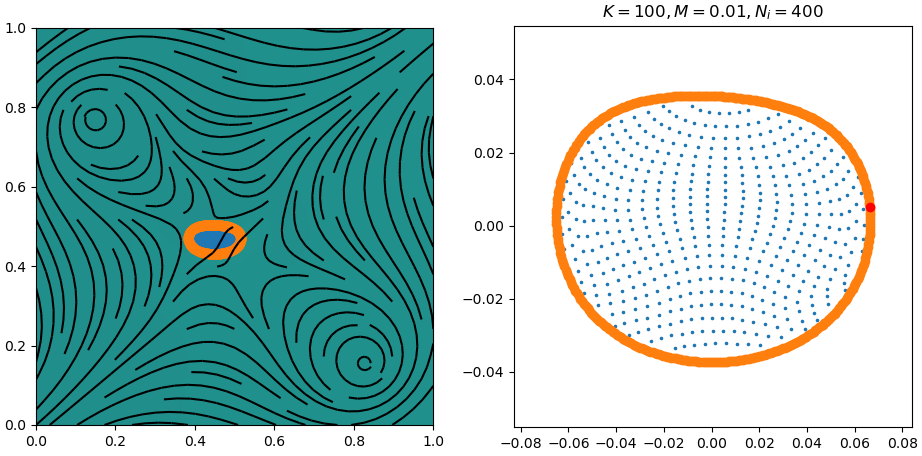

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250


In [5]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
ims = []

for i, u in enumerate(U):
    print(i*10)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin, Xout]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        xout = Xout[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com
        out = xout - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Nb, color=cmap(0)))
        im.append(axj.scatter(out[:,0], out[:,1], color=cmap(1)))
        im.append(axj.scatter([out[0,0]], [out[0,1]], color='red'))  ## Mark theta=0
#         im.append(ax.set_title('t={}'.format(1*fluid.t)))

        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')
